# Numerical Exercises 7

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math

csv_path = "./MDNVE_MCNVT/"
phases = ["Solid", "Liquid", "Gas"]
phases_path = [phase + "/" for phase in phases]
colors = ['tab:blue', 'tab:orange', 'tab:green']

In this exercise I am going to update the code provided in Lab4 so as to include tail corrections and the computation of the radial distribution function $g(r)$, that I will shortly describe in detail. The simulation will be executed via $M(RT)^2$ assuming that the system (which again has the same parameter as in Lab4) is canonical (i.e. number of particle, volume and temperature are constant).

## 7.1

In Lab4 we used the cut-off radius approximation, i.e. we considered totally negligible the inter-particle interaction outside a sphere with fixed radius $r_c$ centered in each particle's position. To enhance this approximation we can include so-called tail correction; these can be related to the radial distribution function $g(r)$, which represents the ratio between probability to find two particles at distance $r$ apart and the the same probability under the assumption of a completely random particle distribution. If we suppose that $g(r)\approx1$ for any $r>r_c$ we obtain the following correction to the potential energy $U$ and pressure $P$ (already in natural units): 
$$\frac{\langle U \rangle_{Tail}}{N} = 8\pi\rho\left(\frac{1}{9r_c^9}-\frac{1}{3r_c^3}\right), \quad \frac{\langle W \rangle_{Tail}}{3N}=32\pi\rho\left(\frac{1}{9r_c^9}-\frac{1}{6r_c^3}\right)$$
After modifying the code to account for this terms I proceed to equilibrate the system.

## 7.2

The equilibration follows the same procedure as in Lab4, with only one major difference, which is the monitored value: when using $M(RT)^2$ algorithm on an NVT system, clearly it does not make any sense to look for a temperature equilibration, since the temperature is already externally fixed; I then decided to evaluate the system equilibration by looking at the potential energy instant values ($10^3$ blocks with $1$ s/b) in all the three phases. During this part I also fine-tuned the Metropolis step $\delta$ so as to achieve a $\approx50\%$ acceptance rate, with these final parameters:
- Solid: $\delta = 0.135$
- Liquid: $\delta = 0.25$
- Gas: $\delta = 10.0$

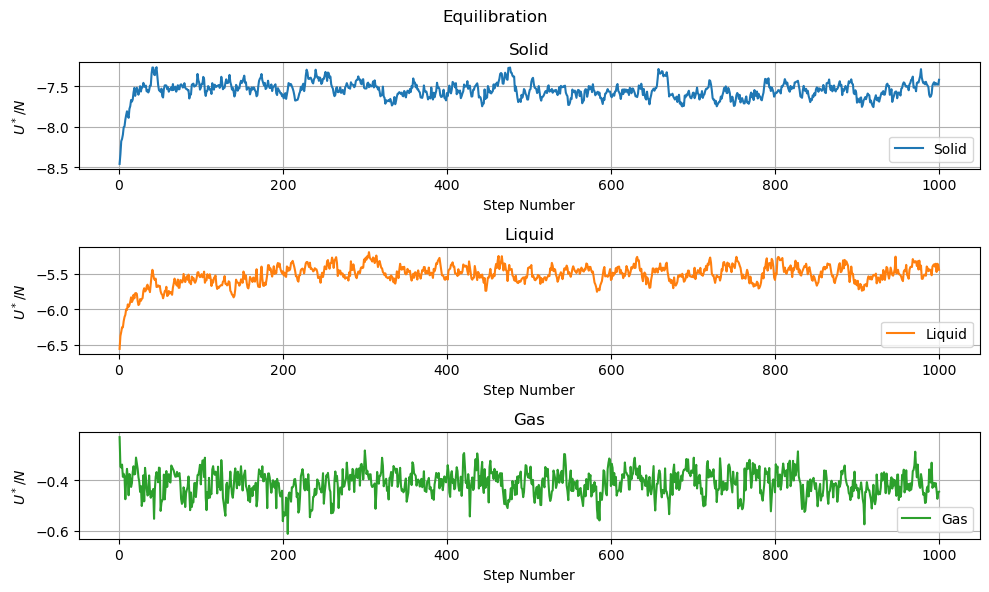

In [14]:
# Temperature is already eq'd in NVT => analyse epot equilibration

eq_path = csv_path + "NonEq/"
eq_directories = map(os.fsencode, [eq_path + phase for phase in phases_path])

for idx, directory in enumerate(eq_directories):

    plt.subplot(3, 1, idx + 1)
    plt.grid(True)

    filename = "output_epot.dat"
    eq_data = np.loadtxt(os.fsdecode(directory) + filename)

    plt.plot(eq_data[:, 0], eq_data[:, 1], color = colors[idx], label = phases[idx])
    plt.xlabel("Step Number")
    plt.ylabel(r"$U^*/N$")
    plt.title(phases[idx])
    plt.legend()

plt.gcf().suptitle("Equilibration")
plt.gcf().set_size_inches(10, 6)
plt.tight_layout()
plt.show()

From the last graph it is clear that after less than $200$ steps the system reaches equilibration in all three phases. I then decided to keep the number of equilibration step equal to $1000$ to safely guarantee equilibration.

Before running the actual simulation, I also need to calibrate the data-blocking parameters (namely the number of steps per block). To do this I am now going to analyze how the auto-correlation function and block-error behave when varying the number of steps per block. 
The auto-correlation function  $\chi(t)$ is used to quantitatively evaluate how much two sample of an observable $O$ taken at "time" $t$ apart (where "time" directly translates to the step number) are related to one another; it is defined as follows: $$\chi(t)=\frac{\frac{1}{t_{max}-t}\sum_{t'=0}^{t_{max}-t}O(t')O(t'+t)-\frac{1}{t_{max}-t}\sum_{t'=0}^{t_{max}-t}O(t')\cdot\frac{1}{t_{max}-t}\sum_{t'=0}^{t_{max}-t}O(t'+t)}{\frac{1}{t_{max}}\sum_{t'=0}^{t_{max}}O^2(t')-\left(\frac{1}{t_{max}}\sum_{t'=0}^{t_{max}}O(t')\right)^2}$$ I will now evaluate $\chi(t)$ using the potential energy as observable $\left(O(t)=\frac{U(t)}{N}\right)$ in the range $t\in[1,500]$, using a large number of steps $M=t_{max}=5\cdot10^5$; I can then choose a reasonable value $\bar{t}$ where $\chi(\bar{t})\approx0$ as the number of steps per block.

In [15]:
# Reference: Lec. 6, slide 30

M = int(5e5)
t_max = M
t_blk_max = int(5e2)

def Autcorr(in_data):

    chi = []

    for t in range(0, t_blk_max):

        sum_a = 0.0
        sum_b = 0.0
        sum_c = 0.0
        sum_d = 0.0
        sum_e = 0.0

        for i in range(0, t_max - t):

            sum_a += (in_data[i] * in_data[i + t])
            sum_b += in_data[i]
            sum_c += in_data[i + t]
            sum_d += in_data[i] ** 2
            sum_e += in_data[i]

        # Do not loop over the whole t_max range => improved efficiency

        for i in range(t_max - t, t_max):

            sum_d += in_data[i] ** 2
            sum_e += in_data[i]

        idelta_t = 1.0 / (t_max - t)
        chi_t = idelta_t * (sum_a - sum_b * idelta_t * sum_c) / (1.0 / t_max * (sum_d - 1.0 / t_max * (sum_e ** 2)))
        chi.append(chi_t)

    return np.asarray(chi)

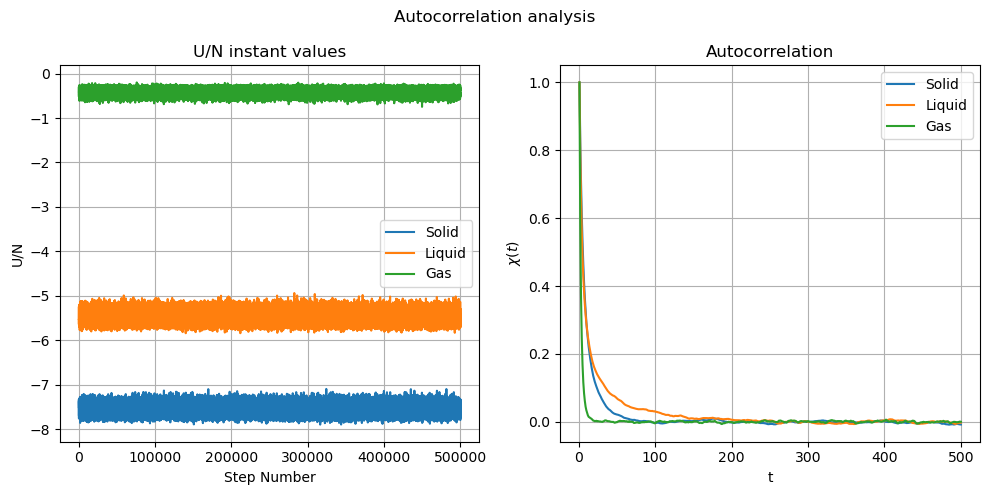

In [16]:
autocorr_path = csv_path + "AutoCorr/"
autocorr_directories = map(os.fsencode, [autocorr_path + phase for phase in phases_path])

autocorr_func_path = "./PythonData/"

plt.figure(figsize=(10,5))

for idx, directory in enumerate(autocorr_directories):

    filename_data = "output_epot.dat"
    filename_autocorr = "output_autocorr.dat"
    autocorr_data = np.loadtxt(os.fsdecode(directory) + filename_data)

    plt.subplot(1, 2, 1)
    plt.plot(autocorr_data[:, 0], autocorr_data[:, 1], label = phases[idx])
    plt.xlabel("Step Number")
    plt.ylabel("U/N")
    plt.title("U/N instant values")
    plt.grid(True)
    plt.legend()

    # Autocorr is a computationally heavy function => save data to speed up code execution

    autocorr = []
    autocorr_file_path = autocorr_func_path + phases_path[idx] + filename_autocorr

    if(os.path.isfile(os.fsencode(autocorr_file_path))):
        
        autocorr = np.loadtxt(autocorr_file_path)

    else:

        autocorr = Autcorr(autocorr_data[:, 1])
        np.savetxt(autocorr_file_path, autocorr)

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, t_blk_max + 1), autocorr, label = phases[idx])
    plt.xlabel("t")
    plt.ylabel("$\chi(t)$")
    plt.title("Autocorrelation")
    plt.grid(True)
    plt.legend()

plt.suptitle("Autocorrelation analysis")
plt.tight_layout()
plt.show()

As we can see from the plot, $\chi(t)\approx0$ for $t>150$: therefore any value $\bar{t}>150$ should be a valid parameter for the number of steps per block. Anyway this analysis is not complete, since the number of steps per block also has a huge impact on the standard deviation of the mean obtained from the data-blocking (which is the best estimator for the statistical error of our measurements), defined as: $$\bar\sigma=\frac{\sigma}{\sqrt{N-1}},\quad \sigma=\sqrt{\frac{1}{N}\sum_i O_i^2-\left(\frac{1}{N}\sum_i O_i\right)^2}$$ where $N$ is the number of samples on which $\bar\sigma$ is computed (i.e. the number of blocks). In order to study the behavior of $\bar\sigma$ and fine-tune $L$ (and consequently $N$), I monitored $\bar\sigma$ while varying $L$ in the range $[10, 5\cdot10^3]$.

In [17]:
def Error(sum, sum2, iblk):

    return math.sqrt(abs(sum2 - sum ** 2) / iblk)

# No need to calculate the error for each block, but only the last block error

def ComputeFinalBlockError(in_data, M, L):

    N = int(M / L)       # Number of blocks

    sum = 0.0
    sum2 = 0.0

    for i in range(0, N):

        # Faster than for loop
        blk_avg = np.sum(in_data[(i * L):((i + 1) * L - 1)]) / L

        sum += blk_avg 
        sum2 += (blk_avg ** 2)

    sum /= N
    sum2 /= N

    return Error(sum, sum2, N)


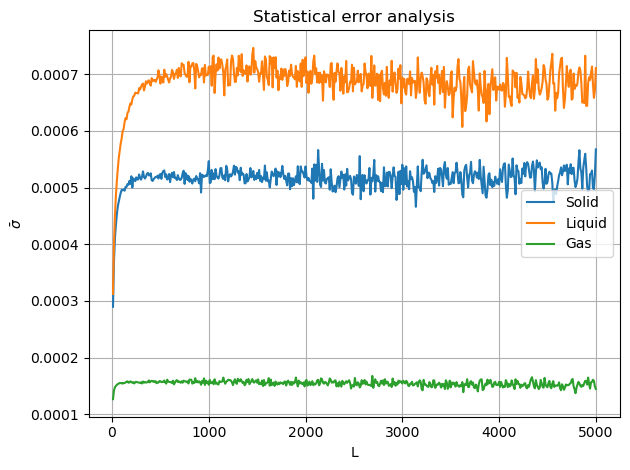

In [22]:
L_min = 10
L_max = int(5e3)
L_range = range(L_min, L_max + 1, 10)       # Step 10 not to overcrowd graph

autocorr_directories = map(os.fsencode, [autocorr_path + phase for phase in phases_path])

for idx, directory in enumerate(autocorr_directories):

    filename_data = "output_epot.dat"
    autocorr_data = np.loadtxt(os.fsdecode(directory) + filename_data)

    last_blk_errors = []

    for L in L_range:

        last_blk_errors.append(ComputeFinalBlockError(autocorr_data[:, 1], M, L))

    plt.plot(L_range, last_blk_errors, label = phases[idx])
    plt.xlabel("L")
    plt.ylabel(r"$\bar\sigma$")
    plt.title("Statistical error analysis")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

From the last plot we can conclude that after $1000$s/b the error stabilizes around a constant value; any lower value for $L$ would result in error under-estimation. In the final simulations I then chose to use $L=2000$ and $N=50$, for a total of $10^5$ steps.  

## 7.3

As a last step before the final simulations, I updated the code to evaluate the radial distribution function $g(r)$ defined as follows: $$g(r)=\frac{1}{\rho N \Delta V(r)}\left\langle\sum_i\sum_{j\neq i}\delta[|\vec{r}|-|\vec{r_i}-\vec{r_j}|]\right\rangle, \quad \Delta V(r)=\frac{4\pi}{3}[(r+dr)^3-r^3]$$
Computationally, $g(r)$ has been evaluated with this procedure:

1. Divide half the volume edge (max. distance between two particles) into $100$ sub-intervals $[r_i, r_i+dr]$ which will be used as bins.
2. For each couple of particles evaluate their distance $\bar{r}$
3. Fill an histogram by updating the bin count by two if $r_i\leq\bar{r}\leq r_i+dr$.

On each histogram bin count data-blocking has been applied, obtaining the results below (the errors could not be seen on the main graph, so I plotted them separately).

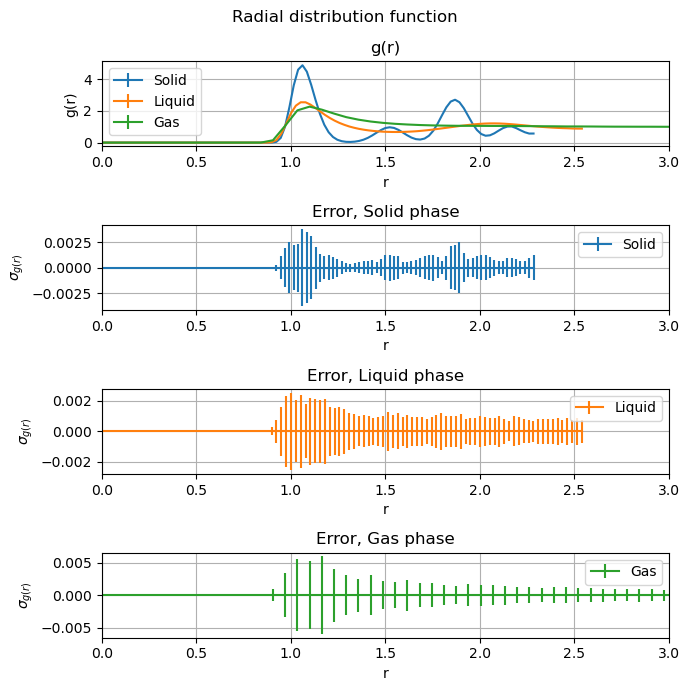

In [27]:
eqd_path = csv_path + "Eq/"
eqd_directories = map(os.fsencode, [eqd_path + phase for phase in phases_path])

plt.figure(figsize=(7,7))

nbins = 100

for idx, directory in enumerate(eqd_directories):

    gr_data = np.loadtxt(os.fsdecode(directory) + "output_gr.dat")

    ax1 = plt.subplot(4, 1, 1)
    plt.errorbar(gr_data[0, :], gr_data[1, :], yerr = gr_data[2, :], label = phases[idx])
    plt.grid(True)
    plt.legend()
    # Gas phase graph extends asymptotically towards g(r) = 1
    plt.xlim(0, 3.0)
    plt.xlabel("r")
    plt.ylabel("g(r)")
    plt.title("g(r)")

    # Graph error bars separately (too small to be seen in main graph)
    plt.subplot(4, 1, 2 + idx, sharex = ax1)
    plt.errorbar(gr_data[0, :], np.zeros(nbins), yerr = gr_data[2, :], label = phases[idx], color = colors[idx])
    plt.xlabel("r")
    plt.ylabel(r"$\sigma_{g(r)}$")
    plt.title("Error, {} phase".format(phases[idx]))
    plt.grid(True)
    plt.legend()

plt.suptitle("Radial distribution function")
plt.tight_layout()
plt.show()

As we can see, $g(r)$ presents (especially in the solid phase) some peaks, which translate in a higher probability of finding twi particle at that distance; this clearly indicates the presence of shells due to the potential. Furthermore, $g(r)$ is identically $0$ for lower $r$, which confirms the presence of a repulsive core, and tends to $1$ for higher values of $r$, in agreement with the assumptions formulated when computing tail corrections.

## 7.4

Finally, I simulated the three phases of Argon, using the tuned parameter for the number of blocks and steps per block. I also computed $g(r)$ via Molecular Dynamics and compared the two results. All the final data are graphed blow.

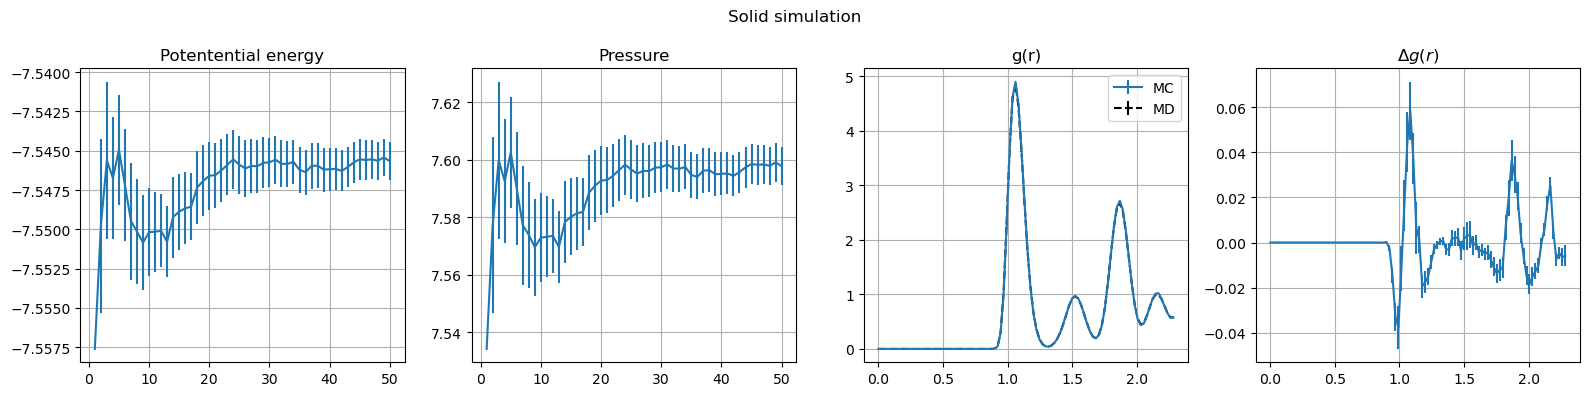

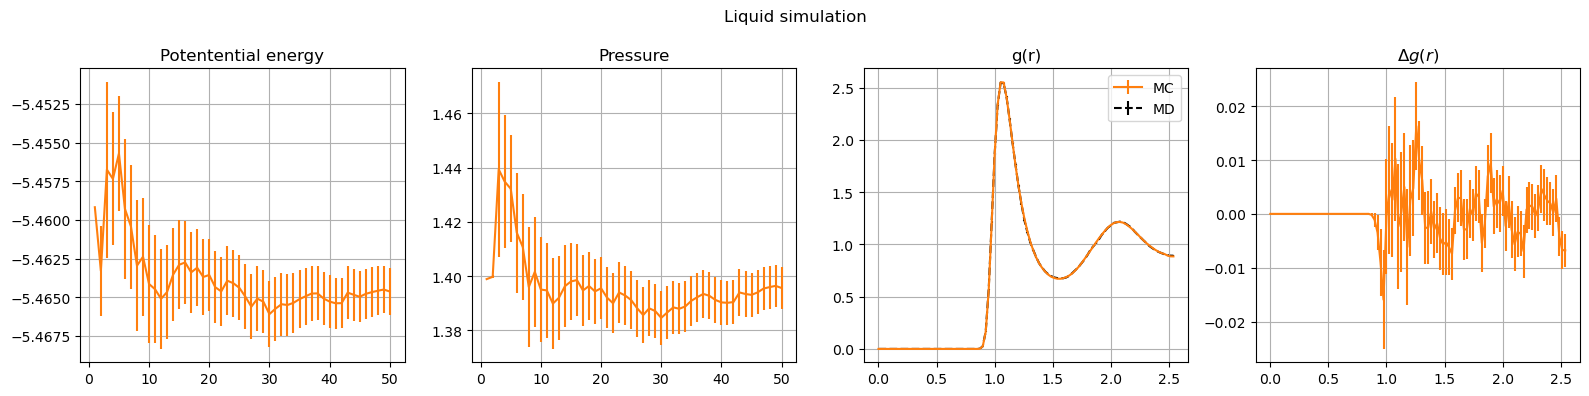

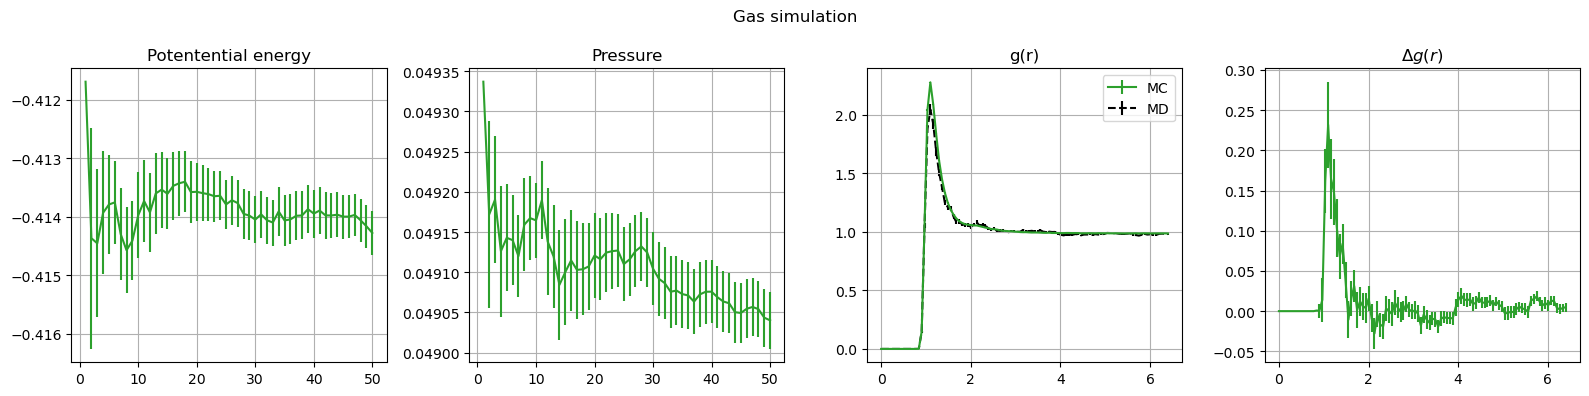

In [39]:
ar_path = csv_path + "ArSim/"
sample_meth = ["MC", "MD"]
sample_meth_path = [smet + "/" for smet in sample_meth]
titles = ["Potentential energy", "Pressure"]
file_names = ["output_epot.dat", "output_pres.dat"]

for idx, phase in enumerate(phases_path):

    plt.figure(figsize=(16,4))
    
    for gidx, fname in enumerate(file_names):

        data_path = ar_path + sample_meth_path[0] + "Eq/" + phase
        data = np.loadtxt(data_path + fname)

        plt.subplot(1, 4, gidx + 1)
        plt.errorbar(data[:,0], data[:,2], yerr=data[:,3], color = colors[idx])
        plt.grid(True)
        plt.title(titles[gidx])

    gr_complete_data = []

    for smidx, smet in enumerate(sample_meth_path):

        data_path = ar_path + smet + "Eq/" + phase

        gr_color = colors[idx]
        gr_ord = 10
        gr_ls = "-"
        if smet == "MD/":
            gr_color = "black"
            gr_ord = 0
            gr_ls = "--"

        gr_data = np.loadtxt(data_path + "output_gr.dat")
        gr_complete_data.append(gr_data)
        plt.subplot(1, 4, 3)
        plt.errorbar(gr_data[0, :], gr_data[1, :], yerr = gr_data[2, :], label = sample_meth[smidx], c = gr_color, zorder = gr_ord, ls = gr_ls)
        plt.grid(True)
        plt.title("g(r)")
        plt.legend()

    # Error in difference between g(r) given by sum of errors, since this is the maximum allowed error

    plt.subplot(1, 4, 4)
    gr_diff = gr_complete_data[0][1, :] - gr_complete_data[1][1, :]
    gr_diff_err = gr_complete_data[0][2, :] + gr_complete_data[1][2, :]
    plt.errorbar(gr_complete_data[0][0, :], gr_diff, yerr = gr_diff_err, color = colors[idx])
    plt.grid(True)
    plt.title(r"$\Delta{g(r)}$")

    plt.suptitle("{} simulation".format(phases[idx]))
    plt.tight_layout()
    plt.show()

If we look at the $g(r)$ from the first plot we may say that the two methods produced compatible results (with a slight disagreement in the peaks) but, if we look ath the difference between the $g(r)$, $\Delta g(r)$, we see that this is only true far away from the peaks (so in a very narrow region for the solid phase); the only phase which has a acceptable overall compatibility is the liquid one.